# Topic Modelling - Latent Dirichlet Allocation (LDA)

This notebook mainly covers the Topic Modelling Section of my Capstone Project.

**Topic modeling** is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. **Latent Dirichlet Allocation (LDA)** is an example of topic modelling and it is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

In [5]:
## Importing Basic Packages
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 50)

# Import NLP Packages
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
from bs4 import BeautifulSoup

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import matplotlib.colors as mcolors

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Reading in Combined Reviews CSV File

combined_reviews = pd.read_csv(r"C:\Users\Andy\Desktop\新增資料夾 (2)\elite_useful10_process_forkeyword.csv")
combined_reviews.drop(['Unnamed: 0'], axis=1, inplace = True)
print(combined_reviews.shape)
combined_reviews.head(3)

(62607, 7)


,user_id,business_id,stars,useful,text,processed,sentiment
0,--2vR0DIsmQ6WfcSzKWigw,nk7fI9Vj7L-kKdXOB7cKIw,5,107,Auf unserem Spaziergang durch das historische ...,auf unserem spaziergang durch das historische ...,1
1,--2vR0DIsmQ6WfcSzKWigw,YiEBSn8VWhnj79igNkShQw,4,112,Auf unserem Rundgang durch das historische Phi...,auf unserem rundgang durch da historische phil...,1
2,--2vR0DIsmQ6WfcSzKWigw,Mkr1Bm0SFo51L5-swly0bw,5,110,Auf unserem Weg durch die Altstadt von Philade...,auf unserem weg durch die altstadt von philade...,1


As seen from the table above, it seems like these reviews are written in non-english languages or are gibberish. Thus, sentimet analysis libraries are not able to compute relevant scores for these reviews. Hence, for the purpose of this project, we will be removing these `630` rows of reviews.

In [8]:
# Converting words in reviews to a list

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list

data = combined_reviews.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['auf', 'unserem', 'spaziergang', 'durch', 'das', 'historische', 'philadelphia', 'haben', 'wir', 'auch', 'das', 'irish', 'memorial', 'gestreift', 'es', 'befindet', 'sich', 'nur', 'unweit', 'vom', 'delaware', 'river', 'und', 'von', 'penns', 'landing', 'uber', 'der', 'in', 'einem', 'park', 'das', 'denkmal', 'ist', 'etwa', 'meter', 'hoch', 'meter', 'lang', 'und', 'meter', 'breit', 'und', 'befindet', 'sich', 'auf', 'einem', 'gewaltigen', 'granitsockel', 'die', 'lebensgroßen', 'skulpturen', 'sollen', 'den', 'hunger', 'und', 'das', 'leid', 'in', 'irland', 'darstellen', 'am', 'ostlichen', 'unteren', 'ende', 'des', 'memorials', 'wird', 'das', 'harte', 'leben', 'und', 'die', 'armut', 'in', 'irland', 'gezeigt', 'von', 'der', 'anderen', 'seite', 'erkennt', 'man', 'ein', 'schiff', 'mit', 'kurs', 'auf', 'amerika', 'folgende', 'inschrift', 'von', 'peter', 'qinn', 'kann', 'man', 'lesen', 'the', 'hunger', 'ended', 'but', 'it', 'never', 'went', 'away', 'it', 'was', 'there', 'in', 'silent', 'memories',

In [9]:
# Text Processing

import spacy

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [10]:
# Create Dictionary

id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency

corpus = [id2word.doc2bow(text) for text in data_ready]

In [11]:
# Build LDA model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=42,
                                           chunksize=250,
                                           passes=5,
                                           alpha='auto',
                                           iterations=10,
                                           per_word_topics=False)

In [12]:
# Overview of Dominant Topics

pprint(lda_model.print_topics())

[(0,
  '0.023*"place" + 0.017*"time" + 0.013*"really" + 0.010*"great" + '
  '0.009*"drink" + 0.009*"look" + 0.009*"back" + 0.008*"wait" + 0.008*"food" + '
  '0.007*"bar"'),
 (1,
  '0.020*"order" + 0.017*"food" + 0.012*"restaurant" + 0.011*"menu" + '
  '0.010*"sauce" + 0.009*"eat" + 0.008*"fry" + 0.008*"serve" + 0.008*"chicken" '
  '+ 0.007*"meal"'),
 (2,
  '0.025*"store" + 0.021*"coffee" + 0.015*"shop" + 0.012*"item" + 0.012*"ice" '
  '+ 0.011*"find" + 0.011*"cream" + 0.009*"chocolate" + 0.009*"cake" + '
  '0.009*"buy"'),
 (3,
  '0.015*"call" + 0.015*"tell" + 0.010*"time" + 0.009*"ask" + 0.008*"day" + '
  '0.008*"service" + 0.008*"work" + 0.007*"give" + 0.007*"pay" + '
  '0.007*"never"'),
 (4,
  '0.014*"room" + 0.008*"area" + 0.007*"parking" + 0.007*"year" + '
  '0.006*"floor" + 0.006*"park" + 0.006*"hotel" + 0.005*"day" + 0.005*"great" '
  '+ 0.005*"live"')]


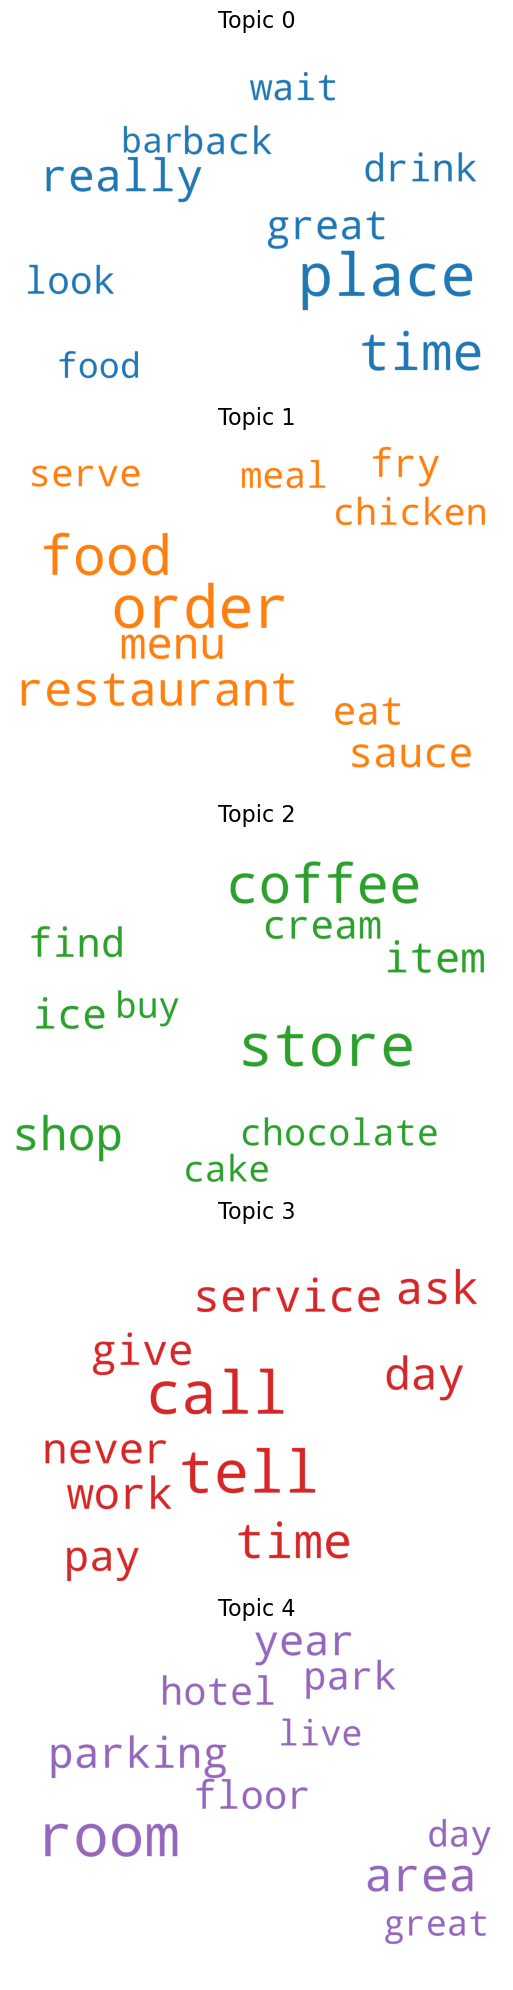

In [13]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 1, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Based on these plots, we can argue that topics 2, 3 and 4 exhibit unique characteristics as compared to topics 0 and 1. **Topic 2** showcases words commonly belonging to **Western Restaurants**. **Topic 3** showcases words belonging to **Dessert Restaurants**. **Topic 4** showcases words belonging to **Asian Restaurants.**

In [14]:
# 5 topics

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\Andy\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.226849 -0.074050       1        1  30.471034
0      0.089111 -0.097274       2        1  27.221290
1     -0.190189 -0.135275       3        1  21.426599
4      0.064837  0.227755       4        1  13.787912
2     -0.190607  0.078844       5        1   7.093165, topic_info=         Term          Freq         Total Category  logprob  loglift
476      call  30221.000000  30221.000000  Default  30.0000  30.0000
674      food  37309.000000  37309.000000  Default  29.0000  29.0000
150     store  11628.000000  11628.000000  Default  28.0000  28.0000
47      place  48226.000000  48226.000000  Default  27.0000  27.0000
692     order  41640.000000  41640.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
1351     stop   2002.686627  10013.149097   Topic5  -5.4377   1.0366
572       new   2119.924313  18920.045544   Topic5  -5.3808   0.4572
742     offer   1959.547532  12674.619508   Topic5  -5.4595   0.7792
1379  quality   1890.108645   6740.772985   Topic5  -5.4955   1.3745
1178    great   1909.491671  32402.610213   Topic5  -5.4853  -0.1854

[369 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
5536       5  0.998341  accessory
2479       4  0.999505   activity
983        2  0.999595    airport
4796       2  0.975155    alcohol
4796       3  0.009981    alcohol
...      ...       ...        ...
854        2  0.095119       year
854        3  0.057252       year
854        4  0.321040       year
854        5  0.024232       year
11330      4  0.999034       yoga

[710 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 5, 3])

In [15]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [16]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

C:\Users\Andy\AppData\Local\Temp\ipykernel_4160\4106086198.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)


In [17]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Keywords', 'Text']
print(df_dominant_topic.shape)
df_dominant_topic.head(10)

(62607, 4)


,Document_No,Dominant_Topic,Keywords,Text
0,0,4,"room, area, parking, year, floor, park, hotel,...","[unserem, durch, auch, irish, memorial, gestre..."
1,1,3,"call, tell, time, ask, day, service, work, giv...","[unserem, durch, sind, auch, die, first, bank,..."
2,2,4,"room, area, parking, year, floor, park, hotel,...","[unserem, durch, die, statue, gestoßen, signer..."
3,3,4,"room, area, parking, year, floor, park, hotel,...","[und, befindet, die, staaten, aller, befand, d..."
4,4,2,"store, coffee, shop, item, ice, find, cream, c...","[ausflug, nordosten, hi, man, ladengeschafte, ..."
5,5,4,"room, area, parking, year, floor, park, hotel,...","[denkmalpflege, die, historic, front, street, ..."
6,6,4,"room, area, parking, year, floor, park, hotel,...","[wir, nur, durch, reingegangen, nach, einer, b..."
7,7,4,"room, area, parking, year, floor, park, hotel,...","[man, die, auswahl, und, die, durch, parkplatz..."
8,8,1,"order, food, restaurant, menu, sauce, eat, fry...","[der, gunstigen, parkplatze, sind, wir, auch, ..."
9,9,0,"place, time, really, great, drink, look, back,...","[haben, ausflug, mall, die, und, court, ublich..."


In [18]:
# Append new columns onto reviews dataset

df_dominant_topic['Text_Chunks'] = df_dominant_topic['Text']
extra_feature_columns = df_dominant_topic[['Dominant_Topic', 'Keywords', 'Text_Chunks']]
final_reviews = pd.concat([combined_reviews,extra_feature_columns], axis=1).reindex(combined_reviews.index)
final_reviews.head(10)

,user_id,business_id,stars,useful,text,processed,sentiment,Dominant_Topic,Keywords,Text_Chunks
0,--2vR0DIsmQ6WfcSzKWigw,nk7fI9Vj7L-kKdXOB7cKIw,5,107,Auf unserem Spaziergang durch das historische ...,auf unserem spaziergang durch das historische ...,1,4,"room, area, parking, year, floor, park, hotel,...","[unserem, durch, auch, irish, memorial, gestre..."
1,--2vR0DIsmQ6WfcSzKWigw,YiEBSn8VWhnj79igNkShQw,4,112,Auf unserem Rundgang durch das historische Phi...,auf unserem rundgang durch da historische phil...,1,3,"call, tell, time, ask, day, service, work, giv...","[unserem, durch, sind, auch, die, first, bank,..."
2,--2vR0DIsmQ6WfcSzKWigw,Mkr1Bm0SFo51L5-swly0bw,5,110,Auf unserem Weg durch die Altstadt von Philade...,auf unserem weg durch die altstadt von philade...,1,4,"room, area, parking, year, floor, park, hotel,...","[unserem, durch, die, statue, gestoßen, signer..."
3,--2vR0DIsmQ6WfcSzKWigw,YHau-ky1o9hm1jare21Syw,5,99,Im Altstadtviertel von Philadelphia zwischen M...,m altstadtviertel von philadelphia zwischen ma...,1,4,"room, area, parking, year, floor, park, hotel,...","[und, befindet, die, staaten, aller, befand, d..."
4,--2vR0DIsmQ6WfcSzKWigw,krCwF4raTYvBcCEwcbA88Q,4,67,Nach einem verunglückten Besuch der Germantown...,nach einem verunglückten besuch der germantown...,1,2,"store, coffee, shop, item, ice, find, cream, c...","[ausflug, nordosten, hi, man, ladengeschafte, ..."
5,--2vR0DIsmQ6WfcSzKWigw,3woevNT4gDDZWTFf94qlCg,4,107,Eine beliebte Sehenswürdigkeit in Philadelphia...,eine beliebte sehenswürdigkeit philadelphia is...,1,4,"room, area, parking, year, floor, park, hotel,...","[denkmalpflege, die, historic, front, street, ..."
6,--2vR0DIsmQ6WfcSzKWigw,6yR6piTIuUG_9P_ctivxKw,5,76,In das Macy´s in Philadelphia sind wir nur dur...,da macy´s philadelphia sind wir nur durch eine...,1,4,"room, area, parking, year, floor, park, hotel,...","[wir, nur, durch, reingegangen, nach, einer, b..."
7,--2vR0DIsmQ6WfcSzKWigw,3UhSCgqvl444e4j3l4HXyQ,5,125,An der Waterfront in Santa Barbara hat man die...,der waterfront santa barbara hat man die auswa...,1,4,"room, area, parking, year, floor, park, hotel,...","[man, die, auswahl, und, die, durch, parkplatz..."
8,--2vR0DIsmQ6WfcSzKWigw,6RUY3l7pQKk1HhM3uwGQSA,4,100,Aufgrund der günstigen Parkplätze sind wir auc...,aufgrund der günstigen parkplätze sind wir auc...,1,1,"order, food, restaurant, menu, sauce, eat, fry...","[der, gunstigen, parkplatze, sind, wir, auch, ..."
9,--2vR0DIsmQ6WfcSzKWigw,iqJ3t9iq0fsWaYL93s8Vmw,5,68,"Als wir in Philadelphia waren, haben wir auch ...","als wir philadelphia waren , haben wir auch no...",1,0,"place, time, really, great, drink, look, back,...","[haben, ausflug, mall, die, und, court, ublich..."


In [19]:
# Save final_reviews into csv file

final_reviews.to_csv(r"C:\Users\Andy\Desktop\新增資料夾 (2)\elite_useful10_process_keyword.csv")